In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import os
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

In [2]:
import os.path as osp
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame

In [3]:
os.chdir("../")

In [5]:
## 원하는 config, checkpoint 경로
config_path = '/opt/ml/detection/main/level2-object-detection-level2-cv-14/mmdetection/configs/jsw_0/cascadeRCNN_swin_s_rpn.py'
checkpoint_path = '/opt/ml/detection/main/level2-object-detection-level2-cv-14/work_dirs/cascadeRCNN_swin_s_rpn/best_bbox_mAP_50_epoch_30.pth'

In [6]:
cfg = Config.fromfile(config_path)
seed = 42
cfg.data.test.test_mode = True

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

load checkpoint from local path: /opt/ml/detection/main/level2-object-detection-level2-cv-14/work_dirs/cascadeRCNN_swin_s_rpn/best_bbox_mAP_50_epoch_30.pth


In [8]:
model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 488/488, 8.9 task/s, elapsed: 55s, ETA:     0s

In [15]:
coco = COCO(cfg.data.val['ann_file'])
cats = coco.loadCats(coco.getCatIds())
classes=[cat['name'] for cat in cats]
imgIds = coco.getImgIds() # image index

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


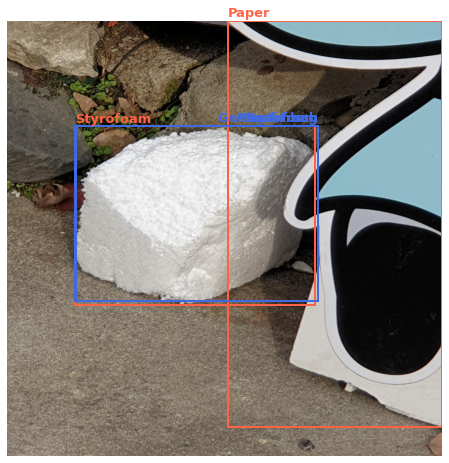

In [80]:
## 원하는 index (0 ~ 487: test:val 0.2 기준)
i = 15
## pred
output_list = []
for c, out in enumerate(output[i]):
    if out.size != 0:
        for box in out:
            bbox = [c, box[0], box[1], box[2] - box[0], box[3] - box[1]]
            output_list.append(bbox)

img = coco.loadImgs(imgIds[i])[0]
annotation_ids = coco.getAnnIds(imgIds = imgIds[i])
anns = coco.loadAnns(annotation_ids)
I = io.imread(os.path.join('./dataset', img['file_name']))
plt.axis('off')
plt.imshow(I)
ax = plt.gca()
for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth = 2, edgecolor = 'tomato',facecolor = 'none')
    ax.add_patch(bb)
    ax.text(box[0], box[1] - 10 , classes[ann['category_id']], weight = 'bold', color = 'tomato', fontsize = 13)
for pred in output_list:
    bb = patches.Rectangle((pred[1], pred[2]), pred[3], pred[4], linewidth = 2, edgecolor = 'royalblue',facecolor = 'none')
    ax.add_patch(bb)
    ax.text(pred[1] + pred[3], pred[2] - 10, classes[pred[0]], weight = 'bold', color = 'royalblue', fontsize = 13, horizontalalignment='right')
plt.show()